<a href="https://colab.research.google.com/github/DeeS17/funnel_analysis_aab_testing/blob/main/proyek_terintegrasi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Konten
  - Tahap 1: Pra-Pemrosesan Data
  - Tahap 2: Memuat Data
  - Tahap 3: Eksplorasi Data
    - Jumlah Peristiwa Yang ada Didalam Dataset
    - Jumlah Pengguna Didalam Dataset
    - Rata-Rata Peristiwa per Pengguna
    - Periode Waktu Data
    - Melihat Frekuensi pada Setiap Peristiwa
    - Melihat Urutan Peristiwa
    - Corong Peristiwa
    - Corong Peristiwa
  - Tahap 4: Analisa Data
    - Jumlah Pengguna Per Kelompok Eksperimen
    - Melihat Pola Peristiwa Kelompok Kontrol
    - Menguji Seluruh Peristiwa Diantara Kelompok Kontrol
    - Menguji Seluruh Peristiwa Antara Kelompok Kontrol dengan Kelompok Uji
    - Menguji Seluruh Peristiwa Antara Kelompok Kontrol dengan Kelompok Uji dengan Nilai Alpha 0.1
  - Tahap 5: Kesimpulan

# Pendahuluan

Sebuah perusahaan *startup* yang menjual produk makanan ingin mengetahui perilaku pengguna aplikasi dari perusahaan tersebut. Untuk mengetahui perilaku pengguna saya kan melakukan melihat corong penjualan dan melihat bagaimana pengguna mencapai tahap pembelian. 

Selain itu *web designer* ingin mengubah *font* untuk keseluruhan aplikasi. Karena itu saya akan melakukan A/A/B testing untuk melihat apakah pengguna merasa terganggu dengan perubahan *font* tersebut.

# Tujuan

- Melihat corong penjualan untuk mengetahui bagaimana pengguna bisa mencapai tahap pembelian.
- Melihat dampak dari perubahan *font* pada seluruh tampilan aplikasi dengan menggunakan metode A/A/B *testing*.

# Tahapan

- Pra-Pemrosesan Data
- Memuat Data
- Eksplorasi Data
- Analisa Data
- Kesimpulan

# Pra-Pemrosesan Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from plotly import graph_objects as go
from scipy import stats
import math

# Memuat Data

In [ ]:
try:
  df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')
except:
  df = pd.read_csv('/content/logs_exp_us.csv', sep='\t')

df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Data telah berhasil dimuat, selanjutnya saya akan memeriksa apakah ada data duplikatnya. 

In [ ]:
df.duplicated().sum()

413

Ternyata ada 413 data duplikat. Karena itu saya akan menghapus data duplikatnya.

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Data duplikatnya telah berhasil dibersihkan.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


Setelah datanya dibersihkan dari dupplikat menyisakan `243,713` baris data. Datanya seluruh lengkap, tidak ada data yang hilang. Hanya kolom `EventName` yang tipe datanya `string`, sisa kolom lainnnya memiliki tipe data `integer`. 

# Eksplorasi Data

## Jumlah Peristiwa yang Ada didalam Dataset

In [ ]:
id_EventCount = df.groupby('DeviceIDHash').agg({'EventName':'count'}).reset_index()
id_EventCount.columns = ['id', 'event_count']
id_EventCount['event_count'].sum()

243713

Sesuai dengan jumlah baris data, ada `243,713` peristiwa didalam dataset.

## Jumlah Pengguna Didalam Dataset

In [ ]:
  id_EventCount.shape[0]

7551

Ada `7,551` pengguna didalam dataset. Selanjutnya saya akan melihat rata-rata peristiwa per pengguna.

## Rata-Rata Peristiwa per Pengguna

In [ ]:
event_qty = id_EventCount['event_count'].sum()
user_qty = id_EventCount.shape[0]
event_per_user = event_qty / user_qty
event_per_user

32.27559263673685

Pada dataset ini, rata-rata setiap pengguna melakukan `32`peristiwa.

## Periode Waktu Data

In [ ]:
df['EventTime'] = pd.to_datetime(df['EventTimestamp'], unit='s')                                         
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId,EventTime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Pada tahap ini saya akan melihat periode waktu yang tercakup didalam data. Sebelum memulainya saya menambahkan kolom `EventTime`. Pada tahap pertama saya akan melihat tanggal awal dan akhirnya. 

In [ ]:
df['EventTime'].min()

Timestamp('2019-07-25 04:43:36')

Data didalam dataset dimulai dari tanggal `25 Juli 2019`.

In [ ]:
df['EventTime'].max()

Timestamp('2019-08-07 21:15:17')

Dan diakhiri pada tanggal `7 Agustus 2019`.

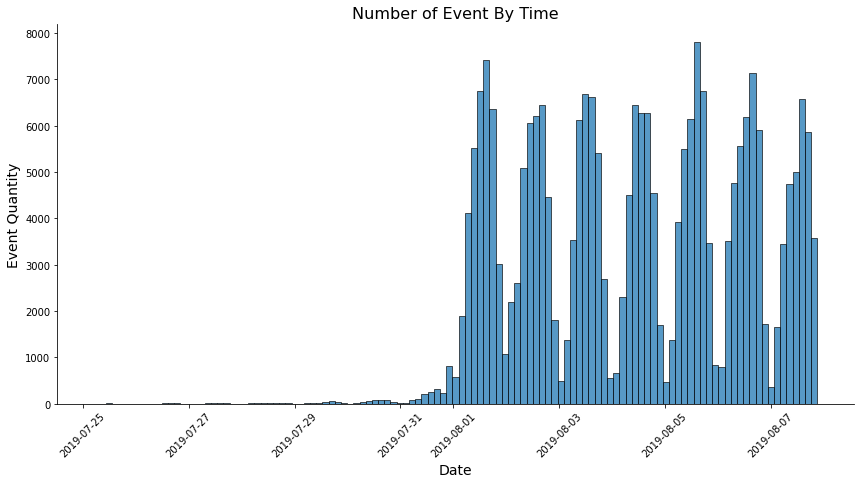

In [ ]:
sns.displot(df, x='EventTime', height=6, aspect=2, palette='mako')
plt.xticks(rotation=45)

plt.title('Number of Event By Time', size=16)
plt.xlabel('Date', size=14)
plt.ylabel('Event Quantity', size=14)
plt.show()

ternyata sebelum tanggal `1 Agustus 2019` datanya belum cukup banyak, baru mulai meningkat pesat setelah tanggal tersebut. Maka dibawah tanggal tersebut dapat dianggap sebagai peristiwa terdahulu bisa saja muncul dalam dataset karena alasan teknis. Karena itu saya akan menyingkirkan data dibawah tanggal `1 Agustus 2019`, setelah itu saya akan memeriksa apakah jumlah datanya masih cukup per kelompok eksperimen.

In [ ]:
df.shape[0]

243713

In [ ]:
df_1 = df.loc[df['EventTime'] >= '2019-08-01'].copy()
df_1.shape[0]

240887

Ternyata hanya kurang dari `300` data yang hilang. Jumlah data syang tersisa tersebut menurut saya masih cukup banyak. Selanjutnya saya akan memeriksa per kelompok eksperimen. 

In [ ]:
df_1['ExpId'].unique()

array([246, 247, 248])

Ternyata masih data yang tersisa per kelompok eksperimen. Oleh karena itu saya akan melanjutkan ke tahap selanjutnya.

## Melihat Frekuensi pada Setiap Peristiwa

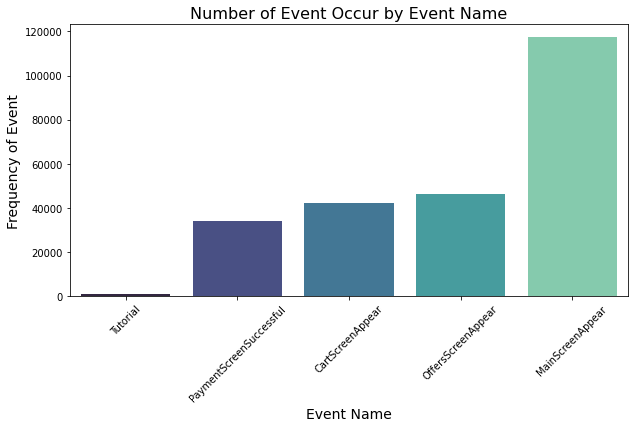

In [ ]:
event_count = df_1.groupby('EventName').agg({'ExpId':'count'}).reset_index()
event_count.columns = ['EventName', 'EventCount']
event_count = event_count.sort_values(by='EventCount')
event_count

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(data = event_count, x='EventName', y='EventCount', ax=ax, palette='mako')

plt.xticks(rotation=45)    
plt.title('Number of Event Occur by Event Name', size=16)
plt.xlabel('Event Name', size=14)
plt.ylabel('Frequency of Event', size=14)
plt.show()

Dari data diatas menunjukan `MainScreenAppear` sedangkan sebaliknya, paling sedikit `Tutorial`. Hal ini sepertinya menunjukan peristiwa `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, dan `PaymentScreenSuccessful` peristiwanya terus berlanjut, sedangkan `Tutorial` tidak.

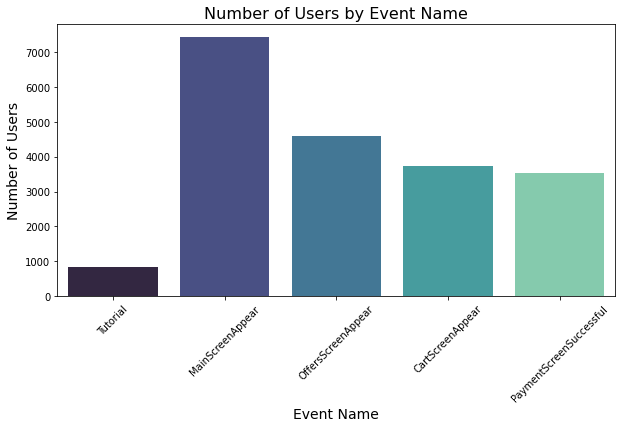

In [ ]:
users_ = []
event_ = df_1['EventName'].unique().tolist()
for event in df_1['EventName'].unique():
  users1 = df_1.loc[df_1['EventName'] == event].groupby('EventName').agg({'DeviceIDHash':'nunique'}).reset_index()
  users2 = users1.loc[0,'DeviceIDHash']
  users_.append(users2)

users_per_event = pd.DataFrame({'event': event_, 'users_count':users_})
users_per_event

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(data = users_per_event, x='event', y='users_count', ax=ax, palette='mako')

plt.xticks(rotation=45)    
plt.title('Number of Users by Event Name', size=16)
plt.xlabel('Event Name', size=14)
plt.ylabel('Number of Users', size=14)
plt.show()

## Melihat Urutan Peristiwa

Pada tahap ini, saya akan memeriksa apakah peristiwa tersebut berurutan seperti dugaan saya pada sebelumnya. Yang mana, peristiwa `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, dan `PaymentScreenSuccessful` merupakan peristiwa bertahap dan terus berlanjut.

In [ ]:
users_event_tbl = df_1.pivot_table(
    index = 'DeviceIDHash',
    columns = ['EventName'],
    values = 'EventTime',
    aggfunc = 'min'
)

users_event_tbl = users_event_tbl[['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']]
users_event_tbl.reset_index(inplace=True)
users_event_tbl.loc[(users_event_tbl['OffersScreenAppear'].isna()) & (~users_event_tbl['PaymentScreenSuccessful'].isna())].head()

EventName,DeviceIDHash,Tutorial,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
161,217208764195819861,NaT,2019-08-01 04:09:57,NaT,2019-08-06 15:09:48,2019-08-06 15:14:16
1237,1568403033187645799,NaT,2019-08-01 12:41:55,NaT,2019-08-01 12:41:58,2019-08-01 12:42:03
1424,1807104407388801321,NaT,2019-08-01 08:17:31,NaT,2019-08-01 10:30:07,2019-08-01 10:33:20
1484,1872850747466641334,2019-08-02 18:39:05,2019-08-03 09:02:56,NaT,2019-08-03 09:03:41,2019-08-05 05:52:44
3946,4880889469135744900,NaT,2019-08-01 06:48:48,NaT,2019-08-02 12:46:21,2019-08-02 12:46:18


Ternyata dugaan saya salah. Karena pada data yang difilter diatas menunjukan ada pengguna yang tidak melalui peristwa `OffersScreenAppear`.

In [ ]:
users_event_tbl.loc[(~users_event_tbl['PaymentScreenSuccessful'].isna()) & (users_event_tbl['CartScreenAppear'].isna())].head()

EventName,DeviceIDHash,Tutorial,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
1999,2546485934419825851,NaT,2019-08-01 12:07:52,2019-08-01 12:08:17,NaT,2019-08-01 12:08:16
2249,2842450591691869422,NaT,2019-08-01 10:39:21,2019-08-04 08:59:21,NaT,2019-08-01 10:39:29
2895,3626993001520930273,NaT,2019-08-01 12:17:31,2019-08-01 12:17:38,NaT,2019-08-01 12:17:33
3618,4518329927200442683,NaT,2019-08-04 09:17:51,2019-08-04 09:17:58,NaT,2019-08-04 09:17:45
4515,5624421956850672353,NaT,2019-08-03 06:29:30,2019-08-03 11:53:26,NaT,2019-08-03 11:53:22


Ternyata dugaan saya juga kembali salah, karena ada pengguna yang tidak melalui peristiwa `CartScreenAppear`.

In [ ]:
users_event_tbl.loc[(~users_event_tbl['PaymentScreenSuccessful'].isna()) & (users_event_tbl['MainScreenAppear'].isna())].head()

EventName,DeviceIDHash,Tutorial,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
54,74158328448226259,NaT,NaT,2019-08-01 09:32:07,2019-08-01 09:32:03,2019-08-01 09:32:02
86,111394506613435756,NaT,NaT,2019-08-02 15:17:28,2019-08-02 15:17:27,2019-08-02 15:17:25
160,214966247576341063,NaT,NaT,2019-08-01 07:02:56,2019-08-01 07:04:01,2019-08-01 07:04:00
196,261817378841141406,NaT,NaT,2019-08-02 10:36:09,2019-08-02 10:36:04,2019-08-02 10:36:03
248,332529825412858125,NaT,NaT,2019-08-01 07:13:37,2019-08-01 07:13:44,2019-08-01 16:06:20


Ternyata dugaan saya juga kembali salah, bahkan ada pengguna yang tidak melalui peristiwa `MainScreenAppear`. Dari ketiga temuan diatas artinya banyak user yang mengakses peristiwa secara tidak berurutan dan bertahap. 

In [ ]:
users_event_tbl1 = users_event_tbl.loc[(~users_event_tbl['MainScreenAppear'].isna()) & (~users_event_tbl['OffersScreenAppear'].isna())].copy()
users_event_tbl2 = users_event_tbl1.loc[(~users_event_tbl['CartScreenAppear'].isna()) & (~users_event_tbl['PaymentScreenSuccessful'].isna())].copy()
users_event_tbl2.head()

EventName,DeviceIDHash,Tutorial,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
1,6909561520679493,NaT,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,2019-08-06 18:52:58
2,6922444491712477,NaT,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,2019-08-04 14:19:40
4,7702139951469979,NaT,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,2019-08-02 14:28:45
7,9841258664663090,2019-08-03 10:47:28,2019-08-03 10:47:59,2019-08-03 10:49:42,2019-08-03 10:52:15,2019-08-03 17:57:27
9,15708180189885246,NaT,2019-08-01 16:08:23,2019-08-01 05:38:55,2019-08-01 11:06:19,2019-08-01 11:06:19


Tetapi tetap ada yang aktifitas peristiwa `MainScreenAppear`, `OffersScreenAppear`, `CartScreenAppear`, dan `PaymentScreenSuccessful` yang lengkap. Oleh karena itu saya akan menghitung corong data peristiwa meskipun itu hanya sebagian dari data yang dapat diolah.  

## Corong Peristiwa

In [ ]:
step_1 = users_event_tbl.loc[~users_event_tbl['MainScreenAppear'].isna()]
step_2 = step_1.loc[(~step_1['OffersScreenAppear'].isna()) & (step_1['OffersScreenAppear'] >= step_1['MainScreenAppear'])]
step_3 = step_2.loc[(~step_2['CartScreenAppear'].isna()) & (step_2['CartScreenAppear'] >= step_2['OffersScreenAppear'])]
step_4 = step_3.loc[(~step_3['PaymentScreenSuccessful'].isna()) & (step_3['PaymentScreenSuccessful'] >= step_3['CartScreenAppear'])]

n_MainScreenAppear = step_1.shape[0]
n_OffersScreenAppear = step_2.shape[0]
n_CartScreenAppear = step_3.shape[0]
n_PaymentScreenSuccessful = step_4.shape[0]

fig = go.Figure(go.Funnel(
    y = ['Main Screen Appear', 'Offers Screen Appear', 'Cart Screen Appear', 'Payment Screen Successful'],
    x = [n_MainScreenAppear, n_OffersScreenAppear, n_CartScreenAppear, n_PaymentScreenSuccessful]
))

fig.update_layout(
    title={
        'text':'Funnel of Event',
        'y':0.9,
        'x':0.5
    }
)

fig.show()

Dari seluruh dataset yang tersisa hanya `7,419` user dan dari visualisasi `funnel` diatas menunjukan ada `1,360` user yang berhasil melakukan pembelian yang secara persentase adalah `9.2%` dari total jumlah user didalam dataset ini. 

Selain itu tahap yang paling banyak kehilangan pengguna adalah pada tahap `Cart Screen Appear`, yang mana ada `1,796` user bertahan atau `42.7%` dibandingkan peristiwa awal. Dan jika dibandingkan jumlah total user didalam dataset persentasenya adalah `24.2%` user yang bertahan.

Sebaliknya tahap yang paling sedikit kehilangan pengguna jika dibandingkan dengan peristiwa sebelumnya adalah pada tahap `Payment Screen Successful`. Ada `75.7%` user yang bertahan jika dibandingkan pada peristiwa sebelumnya. Hal ini dapat dilihat sebagai *insight*. Artinya tim harus memikirkan bagaimana membuat user masuk ke tahap `Cart Screen Appear`, karena peluang user melakukan pembayaran tinggi ketika sudah memasuki tahap tersebut.

# Analisa Data

## Jumlah Pengguna Per Kelompok Eksperimen

In [ ]:
users_per_exp_id = df_1.groupby('ExpId').agg({'DeviceIDHash':'nunique'})
users_per_exp_id.columns = ['users']
users_per_exp_id

,users
ExpId,
246,2484
247,2513
248,2537


Ternyata masih cukup banyak yang tersisa datatanya per kelompok kontrol dan eksperimen. Pada masing-masing kelompok kontrol ada `2,484` dan `2,513` pengguna. Dan pada kelompok uji ada `2,537`.

## Melihat Pola Peristiwa Kelompok Kontrol 

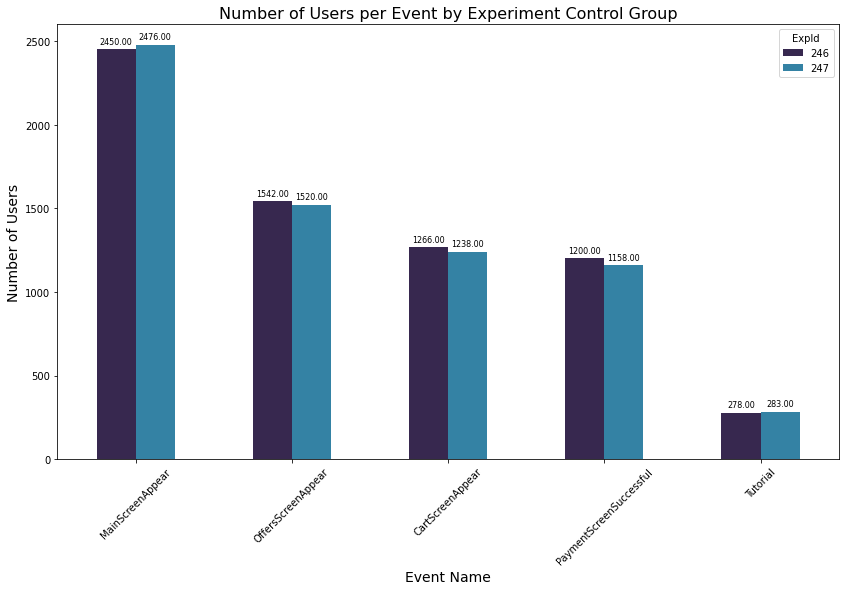

In [ ]:
table_control = df_1.loc[df_1['ExpId'] != 248].pivot_table(
    index='EventName',
    columns = 'ExpId',
    values = 'DeviceIDHash',
    aggfunc = 'nunique'
)
table_control.sort_values(by=246, ascending=False, inplace=True)
plots = table_control.plot(kind='bar', figsize=(14,8), color=['#37284f', '#3482a4'])

for bar in plots.patches:
   
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

plt.title('Number of Users per Event by Experiment Control Group', size=16)
plt.xlabel('Event Name', size=14)
plt.ylabel('Number of Users', size=14)
plt.xticks(rotation = 45)
plt.show()

Peristiwa yang paling populer adalah `MainScreeAppear`, pada kelompok `246` ada sebanyak `2,450` dan pada kelompok `247` ada sebanyak `2,476`. Dari kedua peristiwa paling populer tersebut keduanya lebih kecil dari total `user` masing-masing kelompok kontrol. Artinya tidak semua `user` masuk melalui `MainScreenAppear` diawal. 

## Menguji Statistik Peristiwa yang Populer pada Kelompok Kontrol

Sebelum memulai pengujian saya perlu membuat fungsi pengujian dan membuat hipotesis terlebih dahulu. Berikut hipotesisnya:
- H0: Tidak Ada Perbedaan Proporsi Peristiwa Antara Kelompok Kontrol 246 dengan Kelompok Kontrol 247.
- H1: Ada Perbedaan Proporsi Peristiwa Antara Kelompok Kontrol 246 dengan Kelompok Kontrol 247.

In [ ]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01):
    # proportion of successes in the first group:
    p1 = successes1/trials1

    # proportion of successes in the second group:
    p2 = successes2/trials2

    # proportion of successes in the combined dataset:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # difference in proportions in datasets
    difference = p1 - p2

    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # set standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Menolak hipotesis nol: terdapat perbedaan yang signifikan di antara proporsinya")
    else:
        print("Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda")

check_hypothesis(
    table_control.loc['MainScreenAppear', 246], 
    table_control.loc['MainScreenAppear', 247], 
    users_per_exp_id.loc[246, 'users'], 
    users_per_exp_id.loc[247, 'users']
  )

p-value:  0.7570597232046099
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda


Peristiwa paling populer adalah `MainScreenAppear`, dengan alpha 0.01 gagal menolak `H0`. Karena nilai p-valuenya `0.75`, lebih besar nilai alpha. 

## Menguji Seluruh Peristiwa Diantara Kelompok Kontrol

Karena masih menguji kelompok kontrol, maka hipotesisnya masih sama yaitu:
- H0: Tidak Ada Perbedaan Proporsi Peristiwa Antara Kelompok Kontrol 246 dengan Kelompok Kontrol 247.
- H1: Ada Perbedaan Proporsi Peristiwa Antara Kelompok Kontrol 246 dengan Kelompok Kontrol 247.

In [ ]:
def check_event_hypothesis(users_events_per_group, users_per_group,
                           event,
                           exp1, exp2
                          ):
    print('Peristiwa: '+ event)
    check_hypothesis(users_events_per_group.loc[event, exp1],
                     users_events_per_group.loc[event, exp2],
                     users_per_group.loc[exp1],
                     users_per_group.loc[exp2],
                    )

for event in table_control.index:

  check_event_hypothesis(
      table_control,
      users_per_exp_id,
      event,
      246,
      247
  )
  print('---------------------------------------------------------')

Peristiwa: MainScreenAppear
p-value:  [0.75705972]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: OffersScreenAppear
p-value:  [0.24809546]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: CartScreenAppear
p-value:  [0.22883372]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: PaymentScreenSuccessful
p-value:  [0.11456679]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: Tutorial
p-value:  [0.93769962]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
-------

Berdasarkan dari uji statistik yang telah dilakukan diatas, pada seluruh peristiwa menunjukan `p-value`nya diatas dari nilai alpha. Artinya pada seluruh  peristiwa tidak ada perbedaan diantara kelompok kontrol. 

## Menguji Seluruh Peristiwa Antara Kelompok Kontrol dengan Kelompok Uji

In [ ]:
df_1['control_group'] = df_1['ExpId'] != 248
df_1.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId,EventTime,control_group
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,True
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,True
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,True
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,True
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,True


Pada tahap ini saya akan menguji apakah ada perbedaan yang signifikan antara kelompok uji dengan kelompok kontrol. Karena itu saya menambahkan kolom baru yang bernama `control_group`. Nilai `True` artinya data tersebut adalah kelompok kontrol, sedangkan `False` adalah kelompok uji.

In [ ]:
users_per_control_group = df_1.groupby('control_group').agg({'DeviceIDHash':'nunique'})
users_per_control_group.columns = ['users']
users_per_control_group

,users
control_group,
False,2537
True,4997


Ada `2,537` pengguna yang masuk kedalam kelompok uji, sedangkan pada kelompok kontrol ada sebanyak `4,997` pengguna.

Selain itu sebelum memulai, saya akan merumuskan hipotesis untuk pengujian kali ini. Berikut hipotesisnya:
- H0: Tidak Ada Perbedaan Proporsi Peristiwa Antara Kelompok Kontrol dengan Kelompok Uji
- H1: Ada Perbedaan Proporsi Peristiwa Antara Kelompok Kontrol dengan Kelompok Uji

In [ ]:
table_control_group = df_1.pivot_table(
    index = 'EventName',
    columns = 'control_group',
    values = 'DeviceIDHash',
    aggfunc = 'nunique'
)

table_control_group.sort_values(by=False, ascending=False, inplace=True)

for event in table_control_group.index:

  check_event_hypothesis(
      table_control_group,
      users_per_control_group,
      event,
      True,
      False
  )
  print('---------------------------------------------------------')

Peristiwa: MainScreenAppear
p-value:  [0.29424527]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: OffersScreenAppear
p-value:  [0.4342555]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: CartScreenAppear
p-value:  [0.18175875]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: PaymentScreenSuccessful
p-value:  [0.60042943]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: Tutorial
p-value:  [0.76486247]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
--------

Berdasarkan dari uji statistik yang telah dilakukan diatas, pada seluruh peristiwa menunjukan `p-value`nya diatas dari nilai alpha. Artinya pada seluruh peristiwa tidak ada perbedaan diantara kelompok kontrol dengan kelompok uji. Atau secara praktisnya, dapat diartikan bahwa perubahan *font* yang telah dilakukan oleh *web designer* tidak membuat perilaku pengguna berbeda.

## Menguji Seluruh Peristiwa Antara Kelompok Kontrol dengan Kelompok Uji Dengan Nilai Alpha 0.1

In [ ]:
def check_event_hypothesis_2(users_events_per_group, users_per_group,
                           event,
                           exp1, 
                           exp2,
                           alpha
                          ):
    print('Peristiwa: '+ event)
    check_hypothesis(users_events_per_group.loc[event, exp1],
                     users_events_per_group.loc[event, exp2],
                     users_per_group.loc[exp1],
                     users_per_group.loc[exp2],
                     alpha = alpha
                    )

Pada langkah ini saya akan kembali menguji hipotesis, namun dengan nilai `alpha` `0.1`. Maka sebelum melakukannya saya perlu mengubah sedikit *function* yang digunakan untuk dapat mengubah nilai `alpha` menjadi `0.1`. 

In [ ]:
for event in table_control_group.index:

  check_event_hypothesis_2(
      table_control_group,
      users_per_control_group,
      event,
      True,
      False,
      0.1
  )
  print('---------------------------------------------------------')

Peristiwa: MainScreenAppear
p-value:  [0.29424527]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: OffersScreenAppear
p-value:  [0.4342555]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: CartScreenAppear
p-value:  [0.18175875]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: PaymentScreenSuccessful
p-value:  [0.60042943]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
---------------------------------------------------------
Peristiwa: Tutorial
p-value:  [0.76486247]
Gagal untuk menolak hipotesis nol: tidak ada alasan untuk mempertimbangkan bahwa proporsinya berbeda
--------

Hasilnya adalah tetap tidak ada perbedaan yang signifikan pada semua peristiwa antara kelompok kontrol dengan kelompok uji. Selain itu dengan naiknya batas signifikansi ke `0.1` turut juga meningkatkan resiko terjadi *false positive* atau `kesalahan tipe 1`.

# Kesimpulan

Dari seluruh eksplorasi dan analisa ada beberapa *insight* yang dapat diambil. Poin pertama adalah dari analisa *funnel*. Pada bagian analisa tersebut menunjukan sebanyak `75%` pengguna yang telah masuk kedalam peristiwa `Cart Screen Appear` berhasil melanjutkan ke tahap pembayaran. Artinya jika tujuan akhir yang ingin dituju adalah meningkatkan pendapatan perusahaan, maka yang perlu dilakukan adalah membuat lebih banyak pengguna masuk kedalam peristiwa `Cart Screen Appear`. Karena dari `7,419` pengguna diawal corong, hanya `24%` pengguna yang berhasil masuk ke `Cart Screen Appear`.

Pada poin kedua, yaitu A/A/B *testing* hasilnya tidak ada perbedaan antara dua kelompok kontrol. Dan tidak ada perbedaan antara kelompok kontrol dengan kelompok uji. Artinya perubahan *font* yang dilakukan oleh *web designer* pada keseluruhan aplikasi tidak mengganggu pengguna. Karena tidak ada perubahan perilaku pengguna setelah *font* diubah. 